In [1]:
%matplotlib widget

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ProcessResults import *
from DatasetTester import *
from GetLandmarks_og import GetLandmarks 
#from LandmarkTester_alt import LandmarkTester

from landmark_utils import vis_landmarks, compare_landmarks
from vis_utils import *


import cv2
import numpy as np
import time
import timeit
from pathlib import Path
import csv
import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from scipy import linalg
import seaborn as sns

In [2]:
MEEI_path = Path('./MEEI_Standard_Set')
pat_info = pd.read_excel(MEEI_path/"pat_info.xlsx", sheet_name='Sheet1')

In [3]:
pat_info = pd.read_pickle('MEEI_pat_info.pkl')

with open('all_pats_processed_data.pickle','rb') as f:
    loaded_pats = pickle.load(f)

In [4]:
pat_info

,Category,Sub-category,#,Side,Gender,Age,Path,HB_scale
0,Flaccid,Complete,1,Left,Male,54,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
1,Flaccid,Complete,2,Right,Female,16,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
2,Flaccid,Complete,3,Right,Male,38,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
3,Flaccid,Complete,4,Left,Female,31,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
4,Flaccid,Complete,5,Left,Female,52,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
5,Flaccid,Mild,1,Left,Male,72,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
6,Flaccid,Mild,2,Right,Female,55,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
7,Flaccid,Mild,3,Left,Male,75,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
8,Flaccid,Moderate,1,Left,Male,51,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4
9,Flaccid,Moderate,3,Left,Female,62,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4


In [5]:
# x - choose one
all_ids = loaded_pats[0]
all_imgs = loaded_pats[1]
all_lms = loaded_pats[2]
all_features = loaded_pats[3]

# y
all_hb = loaded_pats[4]

In [6]:
# Find NaN and Inf values
bad_indices = np.where(np.isnan(all_features).sum(axis=1) > 0)[0]
bad_indices = np.append(bad_indices, np.where(np.isinf(all_features).sum(axis=1) > 0)[0])
bad_indices.sort()
bad_indices

array([], dtype=int64)

In [7]:
# drop bad indices 
# x
all_ids = np.delete(all_ids, bad_indices, axis=0)
all_imgs = np.delete(all_imgs, bad_indices, axis=0)
all_lms = np.delete(all_lms, bad_indices, axis=0)
all_features = np.delete(all_features, bad_indices, axis=0)

# y
all_hb = np.delete(all_hb, bad_indices, axis=0)

all_features.shape, all_hb.shape

((408, 29), (408,))

In [8]:
fea_cols = ['f'+str(i) for i in range(0, 29)]
plot_df = pd.DataFrame(all_features, columns = fea_cols)
plot_df['hb'] = all_hb
plot_df['label'] = plot_df['hb'].apply(lambda i: str(i))

In [9]:
plot_df[0:3]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,hb,label
0,1.645194,2.809980,12.804038,1.051468,0.028722,0.049083,0.227269,2.569246,1.085103,1.056966,...,1.708418,11.120797,-18.251646,1.096649,0.762102,0.713114,0.290126,0.124687,6,6
1,0.246923,0.902054,9.176017,1.018437,0.004310,0.015745,0.161535,1.434833,1.038511,1.124336,...,1.411155,4.451960,-3.935614,1.008166,0.679881,0.633601,0.290066,0.122279,6,6
2,1.790182,2.934977,8.810501,1.046135,0.031255,0.051270,0.154996,2.976652,1.081688,1.062997,...,1.599003,9.270165,-21.161253,1.180876,0.736106,0.681453,0.299673,0.124621,6,6


In [10]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(plot_df[fea_cols].values)

plot_df['pca-one'] = pca_result[:,0]
plot_df['pca-two'] = pca_result[:,1] 
plot_df['pca-three'] = pca_result[:,2]
plot_df['pca-four'] = pca_result[:,3]
plot_df['pca-five'] = pca_result[:,4]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.42113987 0.285466   0.18336478 0.05356278 0.02900617]


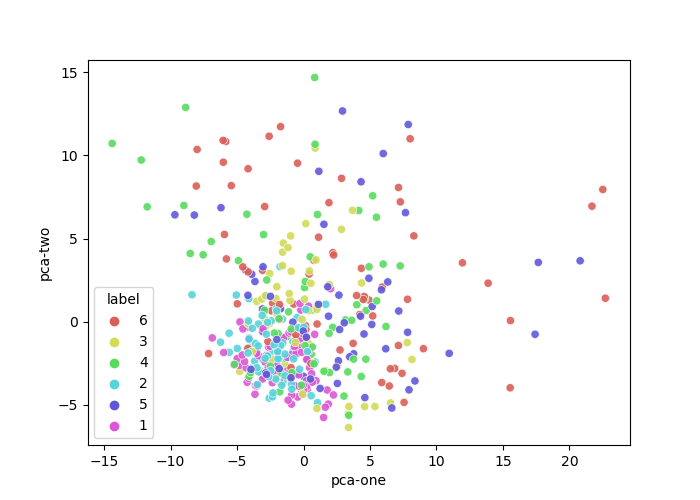

In [11]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 6),
    data=plot_df[:],
    legend="full",
    alpha=0.9)
plt.show()

In [12]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(plot_df[fea_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.000s...
[t-SNE] Computed neighbors for 408 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 1.946278


/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.204071
[t-SNE] KL divergence after 1000 iterations: 1.671947
t-SNE done! Time elapsed: 5.432564735412598 seconds


/tmp/ipykernel_63149/1437045841.py:5: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


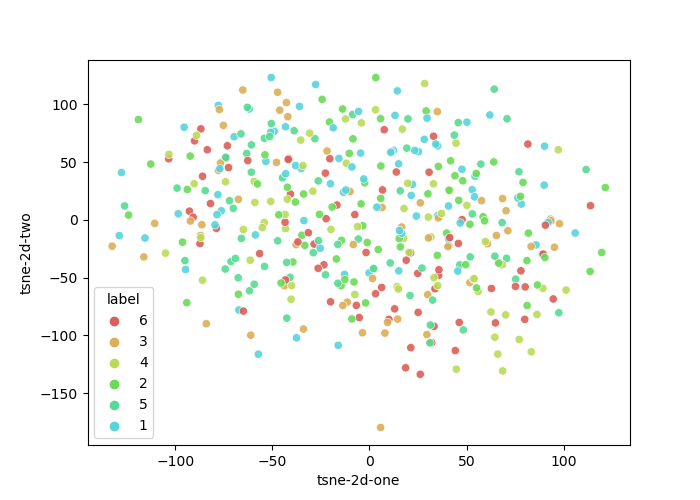

In [13]:
plot_df['tsne-2d-one'] = tsne_results[:,0]
plot_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=plot_df,
    legend="full",
    alpha=0.9)
plt.show()

In [14]:
pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(plot_df[fea_cols].values)

print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9987983107566833


In [15]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_10)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 0.7031288146972656 seconds


/tmp/ipykernel_63149/2289151534.py:4: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


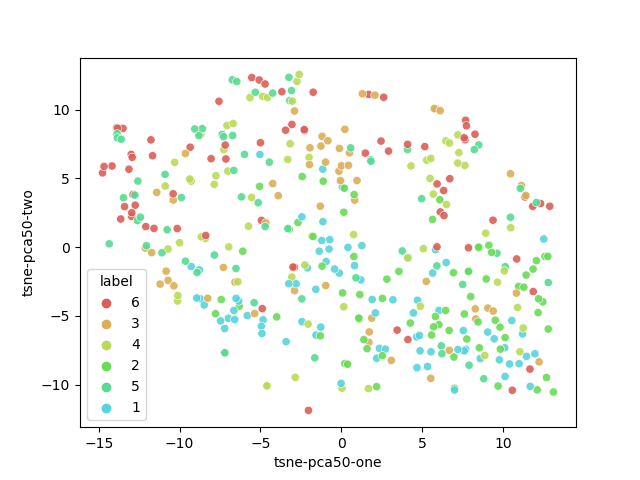

In [16]:
plot_df['tsne-pca50-one'] = tsne_pca_results[:,0]
plot_df['tsne-pca50-two'] = tsne_pca_results[:,1]
ax3 = plt.figure()
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=plot_df,
    legend="full",
    alpha=0.9)
plt.show()

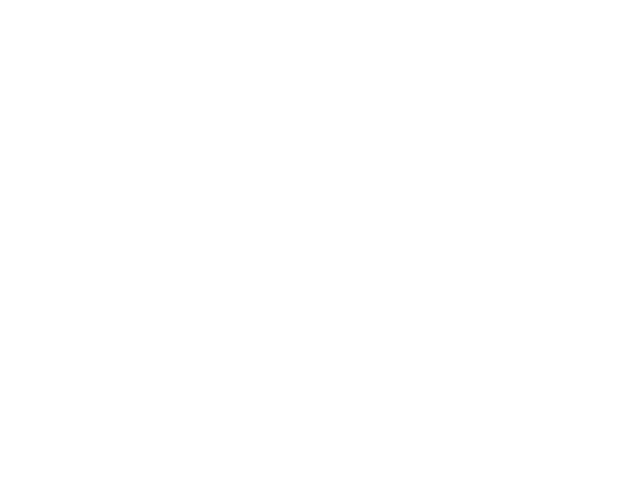

In [17]:
#sns.boxplot(x = plot_df, hue = plot_df['hb'])
plt.figure()
#plt.boxplot(plot_df)
plt.show()

In [18]:
def feature_plot(df, which_feature, group_by):
    sns.displot(df, x=which_feature, hue=group_by, element="step")

In [19]:
#for i in range(0, 29):
#    feature_plot(plot_df, 'f'+str(i), 'hb')

### Now try transformations on the data

In [20]:
scaler = StandardScaler() # standardize features by removing the mean and scaling to unit variance
#scaler = MinMaxScaler() # scale features to lie between 0 and 1
#scaler = PowerTransformer() # apply a power transform featurewise to make data more Gaussian-like
#scaler = QuantileTransformer(output_distribution='normal') # transform features using quantiles information

all_features_scaled = scaler.fit_transform(all_features)
plot_df_scaled = pd.DataFrame(all_features_scaled, columns = ['f'+str(i) for i in range(0, 29)])
plot_df_scaled['hb'] = all_hb
#plot_df.shape, plot_df_scaled.shape
plot_df_scaled['sum'] = plot_df_scaled[['f'+str(i) for i in range(0, 29)]].sum(axis=1)
plot_df_scaled[0:5]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,hb,sum
0,0.788669,0.714530,2.446054,0.965402,0.787717,0.711597,2.456178,2.351332,1.575987,-0.508973,...,0.901177,3.379100,-3.820645,1.547563,-0.475142,-0.664485,0.312672,0.380668,6,31.248367
1,-0.872513,-0.480522,1.428347,-0.241866,-0.871889,-0.480156,1.417740,0.822258,0.108196,0.414976,...,-0.460950,0.762041,-0.731984,-0.804107,-1.625250,-1.745450,0.311004,0.282644,6,-2.796999
2,0.960919,0.792824,1.325815,0.770472,0.959903,0.789782,1.314434,2.900476,1.468403,-0.426258,...,0.399815,2.652855,-4.448388,3.786090,-0.838766,-1.094908,0.581807,0.377956,6,25.547846
3,-1.126220,-0.430071,1.433920,-0.247744,-1.125275,-0.429888,1.423360,-0.113153,0.619490,-0.451998,...,3.905793,1.870380,-2.129643,-0.048409,-0.795492,-0.932834,0.992754,-1.747401,6,10.837042
4,1.038618,1.343192,2.142361,1.070897,1.037581,1.339921,2.143559,2.763428,1.286175,0.094476,...,0.328938,3.138191,-3.740748,2.324289,-0.771391,-1.066314,0.643293,0.823624,6,32.616245


In [21]:
scaler1 = StandardScaler() # standardize features by removing the mean and scaling to unit variance
scaler2 = MinMaxScaler() # scale features to lie between 0 and 1
scaler3 = PowerTransformer() # apply a power transform featurewise to make data more Gaussian-like
scaler4 = QuantileTransformer(output_distribution='normal') # transform features using quantiles information

scaled1 = scaler1.fit_transform(all_features)
scaled2 = scaler2.fit_transform(all_features)
scaled3 = scaler3.fit_transform(all_features)
scaled4 = scaler4.fit_transform(all_features)

/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (408). n_quantiles is set to n_samples.
  warnings.warn(


In [22]:
#for i in range(0, 29):
#    feature_plot(plot_df_scaled, 'f'+str(i), 'hb')

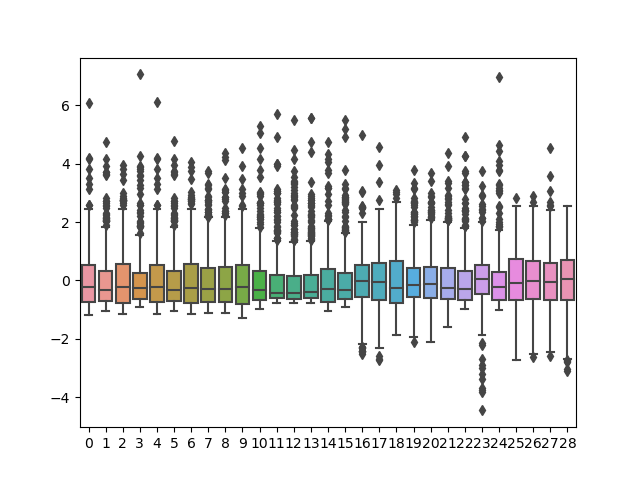

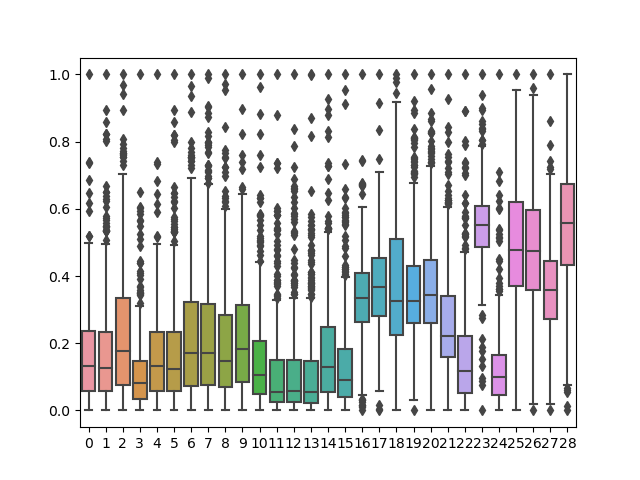

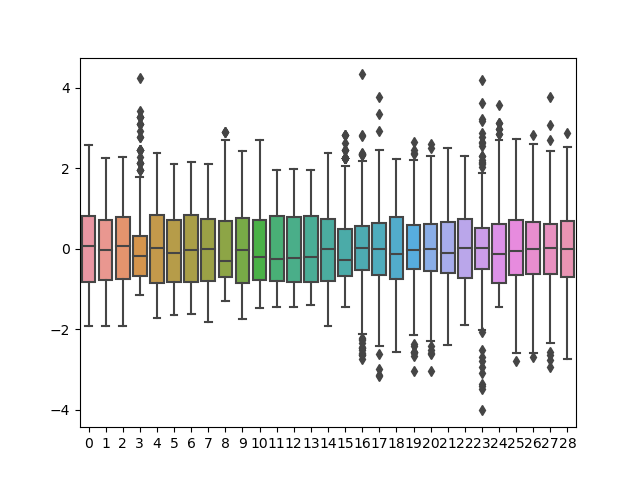

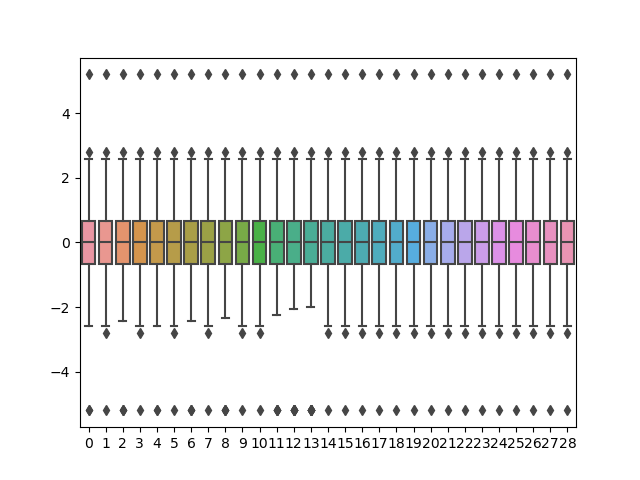

In [23]:
plt.figure()
sns.boxplot(scaled1)
plt.show()

plt.figure()
sns.boxplot(scaled2)
plt.show()

plt.figure()
sns.boxplot(scaled3)
plt.show()

plt.figure()
sns.boxplot(scaled4)
plt.show()

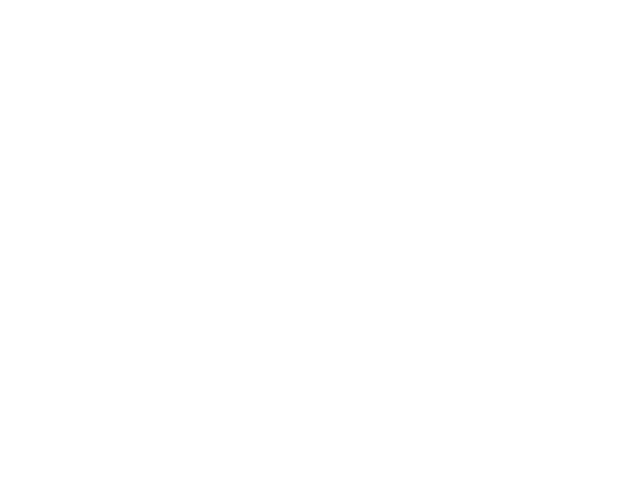

In [24]:
plt.figure()
#sns.histplot(plot_df_scaled)
plt.show()

<AxesSubplot: ylabel='Density'>

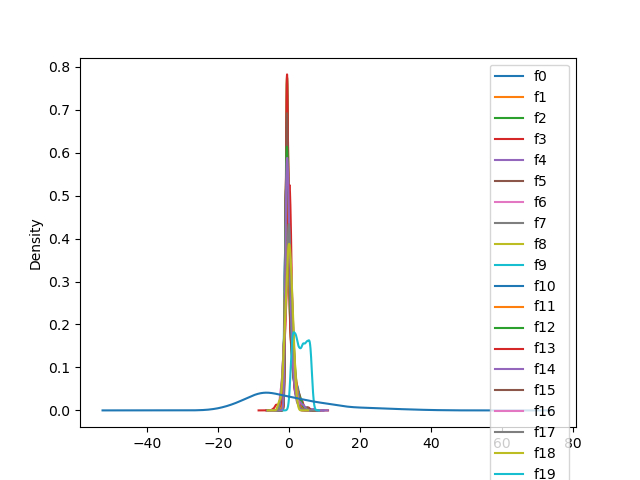

In [25]:
plot_df_scaled.plot.density()

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>,
        <AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'f3'}>,
        <AxesSubplot: title={'center': 'f4'}>,
        <AxesSubplot: title={'center': 'f5'}>],
       [<AxesSubplot: title={'center': 'f6'}>,
        <AxesSubplot: title={'center': 'f7'}>,
        <AxesSubplot: title={'center': 'f8'}>,
        <AxesSubplot: title={'center': 'f9'}>,
        <AxesSubplot: title={'center': 'f10'}>,
        <AxesSubplot: title={'center': 'f11'}>],
       [<AxesSubplot: title={'center': 'f12'}>,
        <AxesSubplot: title={'center': 'f13'}>,
        <AxesSubplot: title={'center': 'f14'}>,
        <AxesSubplot: title={'center': 'f15'}>,
        <AxesSubplot: title={'center': 'f16'}>,
        <AxesSubplot: title={'center': 'f17'}>],
       [<AxesSubplot: title={'center': 'f18'}>,
        <AxesSubplot: title={'center': 'f19'}>,
        <AxesSubplot: title={'center': 'f20'}>,

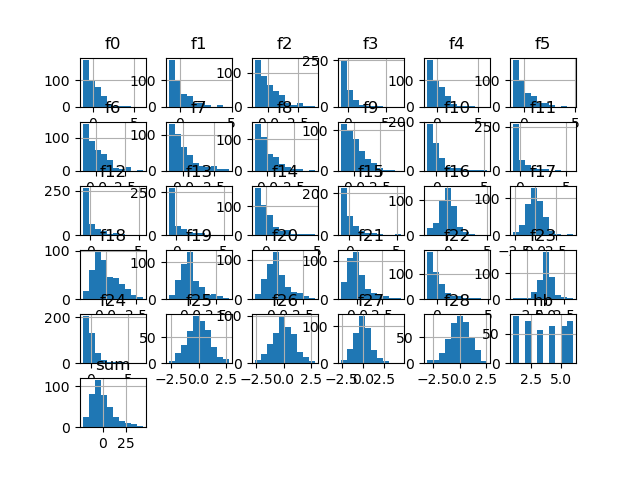

In [26]:
plot_df_scaled.hist()

In [27]:
plot_df = plot_df_scaled
plot_df['label'] = plot_df['hb'].apply(lambda i: str(i))

pca = PCA(n_components=5)
pca_result = pca.fit_transform(plot_df[fea_cols].values)

plot_df['pca-one'] = pca_result[:,0]
plot_df['pca-two'] = pca_result[:,1] 
plot_df['pca-three'] = pca_result[:,2]
plot_df['pca-four'] = pca_result[:,3]
plot_df['pca-five'] = pca_result[:,4]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21413946 0.15286858 0.13256314 0.0758606  0.05715659]


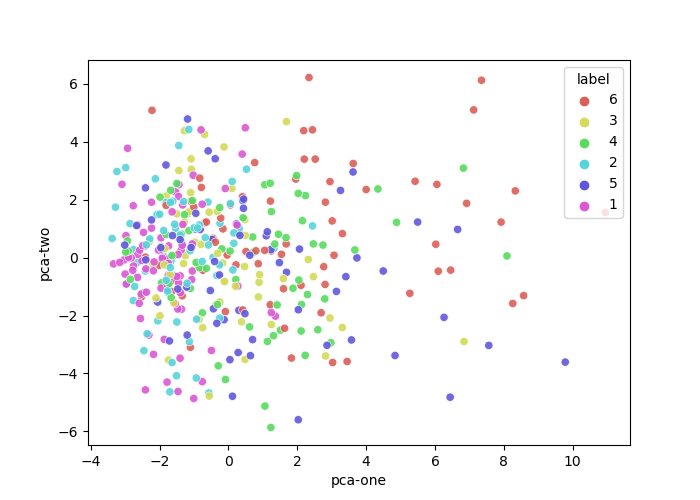

In [28]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 6),
    data=plot_df[:],
    legend="full",
    alpha=0.9)
plt.show()

In [29]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(plot_df[fea_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.000s...
[t-SNE] Computed neighbors for 408 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 1.862330


/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.332481
[t-SNE] KL divergence after 1000 iterations: 0.992389
t-SNE done! Time elapsed: 1.9893546104431152 seconds


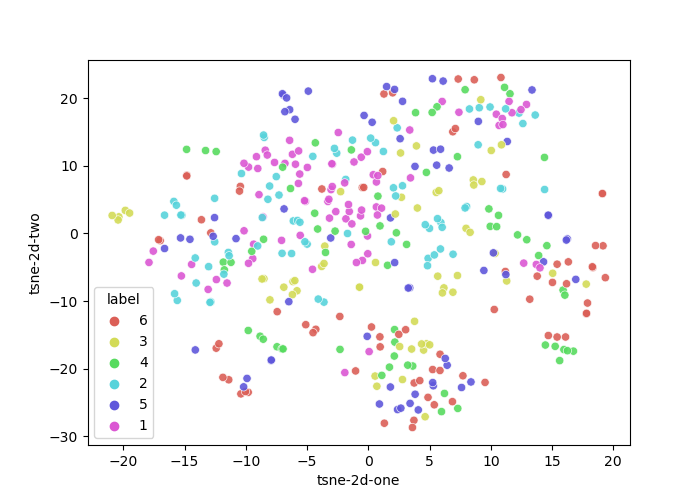

In [30]:
plot_df['tsne-2d-one'] = tsne_results[:,0]
plot_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls"),
    data=plot_df,
    legend="full",
    alpha=0.9)
plt.show()

In [34]:
pca_10 = PCA(n_components=20)
pca_result_10 = pca_10.fit_transform(plot_df[fea_cols].values)

print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9932021498680115


In [35]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1)
tsne_pca_results = tsne.fit_transform(pca_result_10)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.001s...
[t-SNE] Computed neighbors for 408 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 1.855395


/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/bp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.555969
[t-SNE] KL divergence after 1000 iterations: 1.026120
t-SNE done! Time elapsed: 1.0240354537963867 seconds


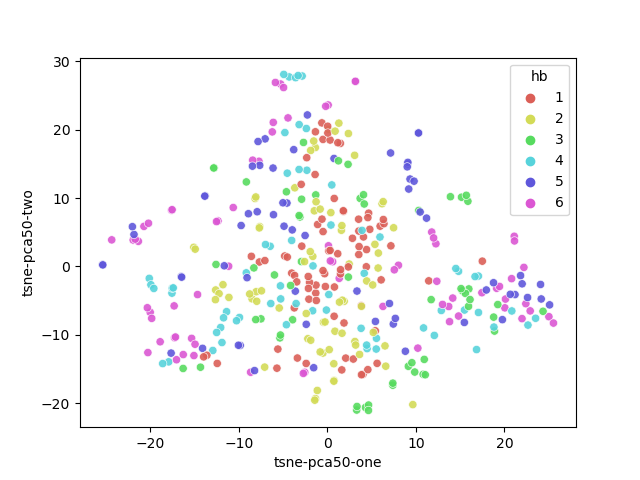

In [37]:
plot_df['tsne-pca50-one'] = tsne_pca_results[:,0]
plot_df['tsne-pca50-two'] = tsne_pca_results[:,1]
ax3 = plt.figure()
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="hb",
    palette=sns.color_palette("hls",6),
    data=plot_df,
    legend="full",
    alpha=0.9)
plt.show()